In [1]:
#Jenna Honeywell MSDS422 Assignment 3

In [2]:
#Use at least four binary (dichotomous) variables of your choice to build models. Predict the binary response variable of
#survival.  Use cross-validation on the training set prior to submitting your forecasts to be graded on the Kaggle.com 
#withheld test set.   Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron
#textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design as well as on the test
#set (minimum of two Kaggle.com submissions).  Use the area under the receiver operating characteristic (ROC) curve as an 
#index of classification as part of cross-validation. Python scikit-learn should be your primary environment for conducting
#this research.

In [3]:
import pandas as pd
import numpy as np
import random as rnd
import pandas_profiling
from pandas_profiling import ProfileReport as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics

In [4]:
titanic_train = pd.read_csv("titanic_train.csv")
titanic_test = pd.read_csv("titanic_test.csv")

In [5]:
pp(titanic_train, title = 'Pandas Profiling Report')
#Running pp to see correlation information, missing values, variable types,
#and variable information

In [6]:
pp(titanic_test, title = 'Pandas Profiling Report')

In [7]:
#Assumptions (tested below)
#More likely to survive: upper class passengers and women 

In [8]:
#Checking the percentage of passengers who surived from each class
titanic_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
#Checking the percentage of passengers who surived from each sex
titanic_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [10]:
#Checking the percentage of passengers who surived who had siblings/spouses on board
titanic_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
#Checking the percentage of passengers who surived who had parents/children on board
titanic_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


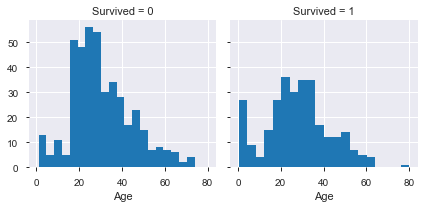

In [12]:
#Plotting age, sex, and survival
age_survival_plot = sns.FacetGrid(titanic_train, col='Survived')
age_survival_plot.map(plt.hist, 'Age', bins=20)

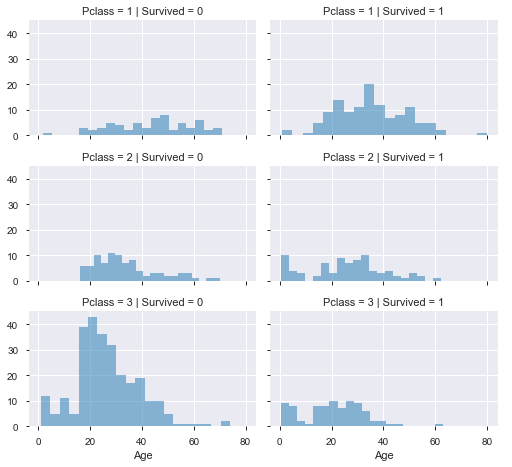

In [13]:
#Adding Pclass to age/survival plots
age_class_survival = sns.FacetGrid(titanic_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
age_class_survival.map(plt.hist, 'Age', alpha=.5, bins=20)
age_class_survival.add_legend();

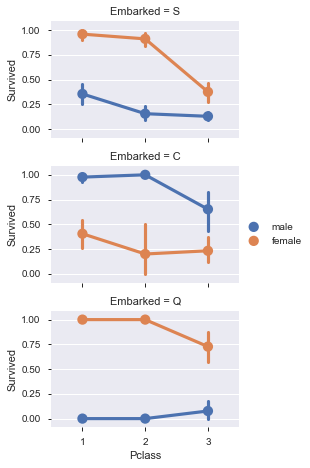

In [14]:
#Looking at survival based on sex and port of embarkation 
embarked_survival = sns.FacetGrid(titanic_train, row='Embarked', size=2.2, aspect=1.6)
embarked_survival.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
embarked_survival.add_legend()

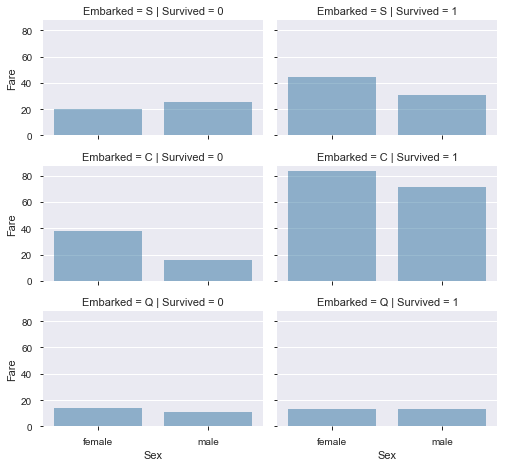

In [15]:
#Looking at survival based on fare and embarkation 
fare_embark = sns.FacetGrid(titanic_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
fare_embark.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
fare_embark.add_legend()

In [16]:
#Based on the above, fare and pclass seem to be adequate indicators of 
#survival.  Dropping cabin as it contains many missing values and ticket
#as it's not much more than an ID.  Dropping from both test and train
titanic_train = titanic_train.drop(['Ticket', 'Cabin'], axis=1)
titanic_test = titanic_test.drop(['Ticket', 'Cabin'], axis=1)
titanic_full = [titanic_train, titanic_test]

In [17]:
#Combing SibSp and Parch to see all relatives - adding dichotomous variables 
#relatives and not_alone 
titanic_full = [titanic_train, titanic_test]
for dataset in titanic_full:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
titanic_train['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [18]:
#Dropping Parch and SibSp as they've been transformed 
titanic_train = titanic_train.drop(['Parch', 'SibSp'], axis=1)
titanic_test = titanic_test.drop(['Parch', 'SibSp'], axis=1)
titanic_full = [titanic_train, titanic_test]

In [19]:
#Dropping ID from test as it's not indicative of anything, it's just an ID 
titanic_train = titanic_train.drop(['PassengerId'], axis=1)
titanic_full = [titanic_train, titanic_test]

In [20]:
#Making sex a dichotomous variable 
for dataset in titanic_full:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

titanic_train.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,S,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,C,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,S,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,8.0500,S,0,1


In [21]:
#Before modeling, NaNs need to be filled.
#Age has many missing values.  Filling with random numbers based on mean
#age in regards to standard deviation
titanic_full = [titanic_train, titanic_test]

for dataset in titanic_full:
    mean = titanic_train["Age"].mean()
    std = titanic_test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = titanic_train["Age"].astype(int)
titanic_train["Age"].isnull().sum()

0

In [24]:
#Filling NaNs in embarked with most common Embarked value 
common_value = 'S'
titanic_full = [titanic_train, titanic_test]

for dataset in titanic_full:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [25]:
#Encoding embarked 
for dataset in titanic_full:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

titanic_train.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,relatives,not_alone
0,0,3,"Braund, Mr. Owen Harris",0,22,7.2500,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,71.2833,1,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26,7.9250,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,53.1000,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35,8.0500,0,0,1


In [26]:
#Filling single NaN value in test
titanic_test['Fare'].fillna(titanic_test['Fare'].dropna().median(), inplace=True)

In [27]:
#Name is not much more than another ID column - pulling titles from names
#as they can be indicative of age and gender which are both important 
#factors in survival 
titanic_full = [titanic_train, titanic_test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}

for dataset in titanic_full:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)
titanic_train = titanic_train.drop(['Name'], axis=1)
titanic_test = titanic_test.drop(['Name'], axis=1)

In [28]:
#Creating groups for ages so it's not a continuous variable 
titanic_full = [titanic_train, titanic_test]
for dataset in titanic_full:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [29]:
#Creating groups for fare so it's not a continuous variable 
titanic_full = [titanic_train, titanic_test]

for dataset in titanic_full:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[(dataset['Fare'] > 250) & (dataset['Fare'] <= 1000), 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [30]:
#Running models 
X_train = titanic_train.drop("Survived", axis=1)
Y_train = titanic_train["Survived"]
X_test  = titanic_test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [31]:
#Logistic Regression cross validation
from sklearn.model_selection import cross_val_score
log_r = LogisticRegression()
log_scores = cross_val_score(log_r, X_train, Y_train, cv=5, scoring = "accuracy")
log_r.fit(X_train, Y_train) 
log_X_pred = log_r.predict(X_train)
log_Y_pred = log_r.predict(X_test)
print("Accuracy of Logistic Regression:", log_scores)
print("Mean of LR:", log_scores.mean())
print("Standard Deviation of LR:", log_scores.std())

Accuracy of Logistic Regression: [0.79329609 0.82022472 0.80337079 0.80898876 0.81460674]
Mean of LR: 0.808097420124286
Standard Deviation of LR: 0.0092914756317843


Area Under the Curve: 0.8045010066148979


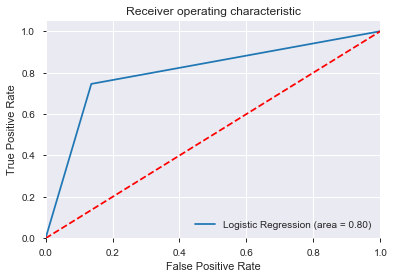

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print("Area Under the Curve:", roc_auc_score(Y_train,log_X_pred))
log_roc_auc = roc_auc_score(Y_train, log_X_pred)
fpr, tpr, thresholds = roc_curve(Y_train, log_X_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [34]:
#Naive Bayes cross validation
nb = GaussianNB()
nb_scores = cross_val_score(nb, X_train, Y_train, cv=5, scoring = "accuracy")
nb.fit(X_train, Y_train)
nb_X_pred = nb.predict(X_train)
nb_Y_pred = nb.predict(X_test)
print("Accuracy of Naive Bayes:", nb_scores)
print("Mean of NB:", nb_scores.mean())
print("Standard Deviation of NB:", nb_scores.std())

Accuracy of Naive Bayes: [0.77653631 0.79213483 0.79213483 0.80898876 0.83707865]
Mean of NB: 0.8013746783001696
Standard Deviation of NB: 0.02059340649204987


Area Under the Curve: 0.7998514044674527


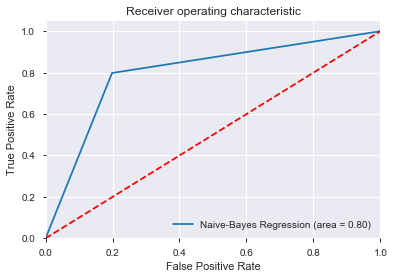

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print("Area Under the Curve:", roc_auc_score(Y_train,nb_X_pred))
nb_roc_auc = roc_auc_score(Y_train, nb_X_pred)
fpr, tpr, thresholds = roc_curve(Y_train, nb_X_pred)
plt.figure()
plt.plot(fpr, tpr, label='Naive-Bayes Regression (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [37]:
log_submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": log_Y_pred
    })
log_submission.to_csv('log_submission.csv', index=False)

In [38]:
nb_submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": nb_Y_pred
    })
nb_submission.to_csv('nb_submission.csv', index=False)

In [39]:
#Note: while this model was trained using 4 dichotomous variables as per the assignment instructions, the best score on 
#Kaggle did NOT come from this training set.  It was a pared down version that eliminated Parch/SibSp data entirely